In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
time_slot = 5*60*1000 # 5 seconds
length = 10 # number of timeslots around
embedded_size = 30
N = 7

In [3]:
DATA_PATH = '/content/gdrive/MyDrive/NCKH/IoT/dataset_17-02-2022.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/IoT/v1_mlp.hdf5'

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

In [4]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)
df['timestamp'] = list(map(lambda x: int(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()),df['timestamp']))
df.head(10)

,sensor,value,timestamp
0,O3,0.20565482974052,1594028407
1,NO2,0,1594028407
2,CO,0.23644705116749,1594028407
3,PRES,100276.1875,1594028407
4,HUM,49.6015625,1594028407
5,TC,25.5,1594028407
6,BAT,58,1594028407
7,O3,0.20122393965721,1594030208
8,NO2,0,1594030208
9,CO,0.16477552056313,1594030208


In [5]:
df.columns, df.shape, df[df.sensor == 'B']

(Index(['sensor', 'value', 'timestamp'], dtype='object'),
 (537187, 3),
       sensor value   timestamp
 40958      B    45  1603750253)

In [ ]:
lst_sensor = list(set(df['sensor']))
lst_sensor.remove('WV')
len(lst_sensor), lst_sensor

(16,
 ['O3',
  'PLV2',
  'B',
  'ANE',
  'NO2',
  'PLV3',
  'PLV1',
  'PM10',
  'PRES',
  'PM25',
  'CO',
  'NOISE',
  'HUM',
  'BAT',
  'LUX',
  'TC'])

In [ ]:
lst_sensor[1],df[df.sensor == lst_sensor[1]].timestamp[:10], df[df.sensor == lst_sensor[1]].value[:10]

('PLV2', 18680    1603730655
 18686    1603730649
 18692    1603730644
 18698    1603730639
 18704    1603730633
 18710    1603730628
 18716    1603730623
 18722    1603730617
 18728    1603730612
 18734    1603730607
 Name: timestamp, dtype: int64, 18680    0.00
 18686    0.00
 18692    0.00
 18698    0.00
 18704    0.00
 18710    0.00
 18716    0.00
 18722    0.00
 18728    0.00
 18734    0.00
 Name: value, dtype: object)

In [ ]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1594027700, 1623141813, 98)

In [ ]:
import more_itertools as mit

X_idx = []
y = []

maximum_value = {}
start_end = {}
normalized_df = pd.DataFrame(columns=df.columns)

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]
  history = subdf.value.astype(np.float32)
  history[history < 0] = 0
  maximum_value[sensor] = np.max(history)
  print("\n\tSensor: ", sensor, " \nMax value: ", maximum_value[sensor], " \nMin value: ", np.min(history))
  history = (history/maximum_value[sensor])
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  start = len(y)
  y.extend(history[N:])
  end = len(y)
  start_end[sensor] = (start,end)
  
  subdf.value = history
  normalized_df = normalized_df.append(subdf)

df = normalized_df
X = np.array(X_idx)
y = np.array(y)
X.shape, y.shape


	Sensor:  O3  
Max value:  0.4146099388599396  
Min value:  0.009625745005905628

	Sensor:  PLV2  
Max value:  46.380001068115234  
Min value:  0.0

	Sensor:  B  
Max value:  45.0  
Min value:  45.0


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value



	Sensor:  ANE  
Max value:  40.79999923706055  
Min value:  0.0

	Sensor:  NO2  
Max value:  0.17887425422668457  
Min value:  0.0

	Sensor:  PLV3  
Max value:  102.54000091552734  
Min value:  0.0

	Sensor:  PLV1  
Max value:  107.56999969482422  
Min value:  0.0

	Sensor:  PM10  
Max value:  10.100000381469727  
Min value:  0.699999988079071

	Sensor:  PRES  
Max value:  100939.109375  
Min value:  99410.7734375

	Sensor:  PM25  
Max value:  8.800000190734863  
Min value:  0.0

	Sensor:  CO  
Max value:  11.349579811096191  
Min value:  0.0

	Sensor:  NOISE  
Max value:  73.00460052490234  
Min value:  0.0

	Sensor:  HUM  
Max value:  100.0  
Min value:  20.390625

	Sensor:  BAT  
Max value:  100.0  
Min value:  36.0

	Sensor:  LUX  
Max value:  21010.0  
Min value:  0.0

	Sensor:  TC  
Max value:  43.7599983215332  
Min value:  20.860000610351562


((486340, 7), (486340,))

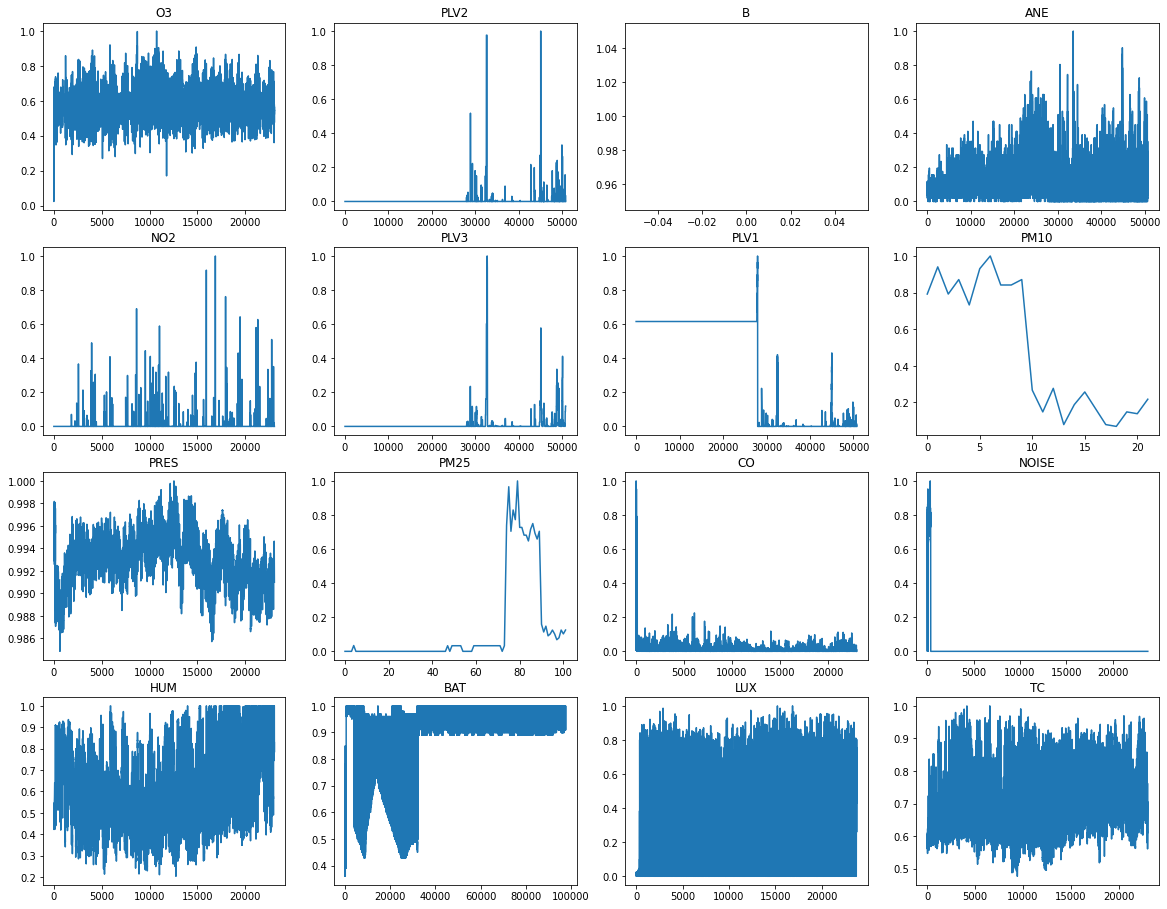

In [ ]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(20,20))

for i,sensor in enumerate(lst_sensor,start=1):
    yy = df[df.sensor==sensor].value
    xx = range(len(yy))
    
    f.add_subplot(5,4,i)
    plt.plot(xx,yy)
    plt.title(sensor)

### split train-test

In [ ]:
y = y.reshape(len(y),1)

In [ ]:
y.shape, X.shape

((486340, 1), (486340, 7))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
len(X) == len(X_train) + len(X_test) + len(X_val), len(y) == len(y_train) + len(y_test) + len(y_val)

(True, True)

In [ ]:
idx = 1000
print(X_train[idx],y_train[idx],sep='\n\n')

[0.17135163 0.16735581 0.13235392 0.11401936 0.09956875 0.09316126
 0.07804349]

[0.08767652]


In [ ]:
X_train.shape, y_train.shape

((350164, 7), (350164, 1))

# MLP

In [ ]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf 
from sklearn.metrics import *

model = Sequential()

input_raw = Input((N))
hidden = Dense(64, activation='relu')(input_raw)
y_pred = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs = input_raw, outputs = y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                512       
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lrate = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=opt, loss=root_mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=10, monitor='val_loss')
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=125,epochs=1000,verbose=True, callbacks=[early_stop,model_checkpoint])

Epoch 1/1000
2802/2802 [==============================] - 7s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.2357 - val_loss: 0.0693 - val_root_mean_squared_error: 0.0702
Epoch 2/1000
2802/2802 [==============================] - 6s 2ms/step - loss: 0.0601 - root_mean_squared_error: 0.0615 - val_loss: 0.0563 - val_root_mean_squared_error: 0.0579
Epoch 3/1000
2802/2802 [==============================] - 6s 2ms/step - loss: 0.0562 - root_mean_squared_error: 0.0578 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0569
Epoch 4/1000
2802/2802 [==============================] - 6s 2ms/step - loss: 0.0555 - root_mean_squared_error: 0.0571 - val_loss: 0.0547 - val_root_mean_squared_error: 0.0563
Epoch 5/1000
2802/2802 [==============================] - 6s 2ms/step - loss: 0.0549 - root_mean_squared_error: 0.0567 - val_loss: 0.0542 - val_root_mean_squared_error: 0.0559
Epoch 6/1000
2802/2802 [==============================] - 6s 2ms/step - loss: 0.0545 - root_mean_squared_error: 0.0562 -

In [ ]:
model.save_weights(WEIGHTS_PATH)

In [ ]:
model.load_weights(WEIGHTS_PATH)

Text(0.5, 1.0, 'lrate=0.0001')

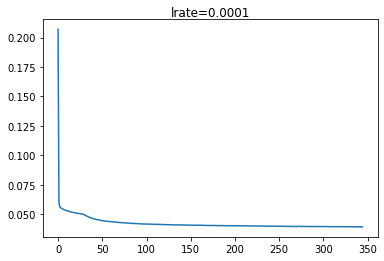

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.title('lrate='+str(lrate), pad=-50)

In [ ]:
mae_model = model.evaluate(X_test, y_test)
print("Root Mean Squared Error of Model = {}".format(mae_model))

3040/3040 [==============================] - 5s 2ms/step - loss: 0.0345 - root_mean_squared_error: 0.0418
Root Mean Squared Error of Model = [0.034543476998806, 0.04180498421192169]


In [ ]:
def plot(y_true,y_pred):
  ar = range(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

In [ ]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)

print("MAE of testset = {}".format(rmse))

MAE of testset = 0.04180499096104248


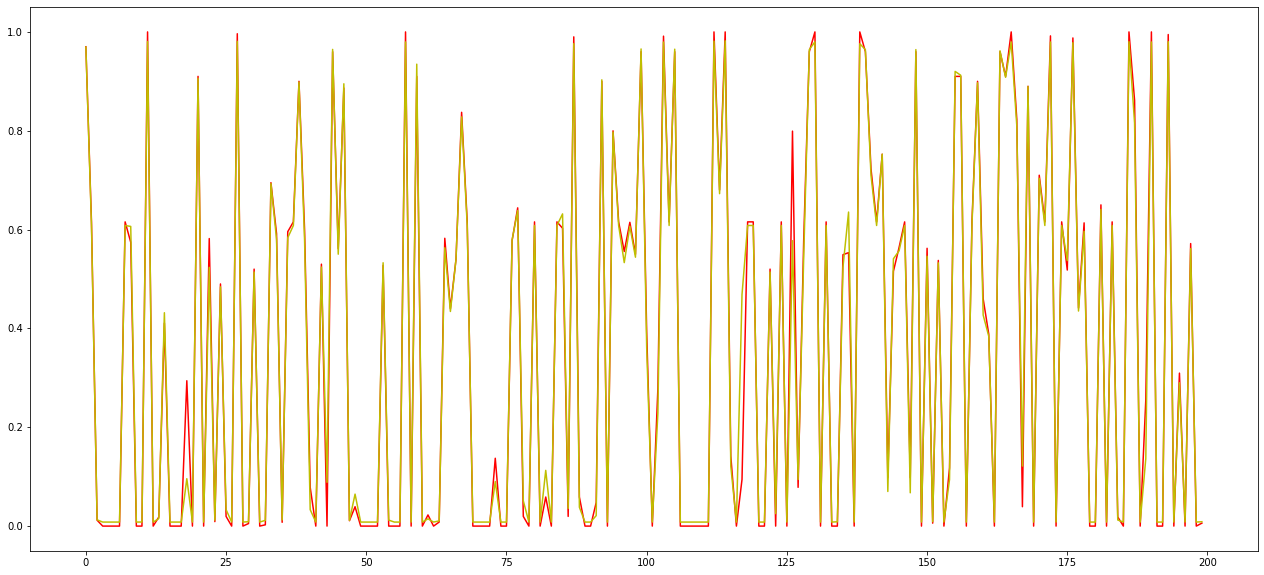

In [ ]:
plot(y_test[:200], y_pred[:200])

In [ ]:
#wrapper
def process(sensor, inp):
  #sensor: sensor id
  #x: array/ndarray of N value in the past
  inp = (np.array(inp)/maximum_value[sensor]).astype(np.float32)
  out = model.predict(np.array([inp]))
  out = out*maximum_value[sensor]

  return out[0][0]

## Infer

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)

idx = 33586
arr = df[df.sensor=='ANE'].value.to_numpy().astype(np.float32)
print("SAMPLE INPUT: ",end='')
print(', '.join(arr[idx:idx+N].astype(str)))
print("EXPECT: ",end='')
print(arr[idx+N])

SAMPLE INPUT: 2.4, 5.6, 3.2, 23.2, 15.2, 40.8, 4.0
EXPECT: 5.6


In [ ]:
#       ^
#       ^
#       |
#       |
# take this sample 

process('ANE',arr[idx:idx+N])

5.7738624